## Import Library

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from xgboost import XGBRegressor
import os

## Import Data

### Define the path

In [207]:
data_path = os.path.join(os.getcwd(), '..', '..', 'data', 'preprocessed_data.csv')

### Read the csv

In [208]:
df = pd.read_csv(data_path)
df.head()

,property_name,room_id,bedroom,bathroom,beds,guests,wifi,tv,cable_tv,ac,...,beachfront,building_staff,lat,lng,booking_window,stay_duration_in_days,avg_rating,avg_review_sentiment_score,rating_count,average_daily_rate
0,Bingin Ombak,431874,1,1,1,2,1,0,0,1,...,1,0,-8.805646,115.113378,81,4,4.3158,0.565051,19,1.477799e+06
1,Bingin Ombak,431875,1,1,1,2,1,0,0,1,...,1,0,-8.805646,115.113378,81,4,4.0857,0.518720,35,1.477799e+06
2,Bingin Ombak,396658,1,1,1,2,1,0,0,1,...,1,0,-8.805646,115.113378,81,4,4.0857,0.518720,35,1.477799e+06
3,Bingin Ombak,396427,1,2,1,2,1,0,0,0,...,1,0,-8.805646,115.113378,81,4,4.5342,0.678392,164,1.477799e+06
4,Bingin Ombak,396427,1,2,1,2,1,0,0,0,...,1,0,-8.805646,115.113378,81,4,4.5342,0.678392,164,1.477799e+06


### Separate features and target variable

In [135]:
X = df.drop(columns=['property_name', 'room_id', 'average_daily_rate'])
y = df['average_daily_rate']

### Split the normalized data into training and testing sets

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Create XGBoost Model

In [137]:
# Initialize the XGBoost model
model = XGBRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
training_mae = mean_absolute_error(y_train, y_pred_train)
print(f'Mean Absolute Error on Training: {training_mae}')

testing_mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Mean Absolute Error on Training: 95612.43582210102
Mean Absolute Error on Testing: 102331.22536129862


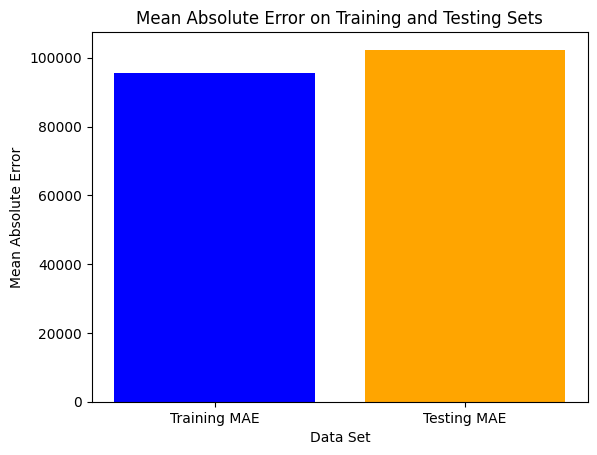

In [138]:
# Plotting the MAE
mae_values = [training_mae, testing_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Tuned The Hyperparameter

In [139]:
# Define the model
tuned_model = XGBRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.3, 0.4, 0.5],
    'max_depth': [9, 10, 11]
}

# Set up the Grid Search
grid_search = GridSearchCV(estimator=tuned_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=5, 
                           verbose=2, 
                           n_jobs=-1)

# Fit the Grid Search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Mean Absolute Error: {-best_score}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  45.5s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  45.7s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  45.9s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  45.9s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  39.7s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time= 1.3min
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time= 1.3min
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time= 1.3min
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time= 1.0min
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time= 1.1min
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=2000; total time= 2.1min
[CV] END ..learning_rate=0.3, max_depth=9, n_es

### Cross Validation

In [140]:
# Define your XGBoost model
model = XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=500, random_state=42)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_test = model.predict(X_test)

# Evaluate the model on the test data
testing_mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Cross-Validation MAE Scores: [86029.88091596 78996.88650418 82676.7526336  82931.39954611
 82406.94535887]
Mean Cross-Validation MAE: 82608.37299174287
Mean Absolute Error on Testing: 78952.62358181538


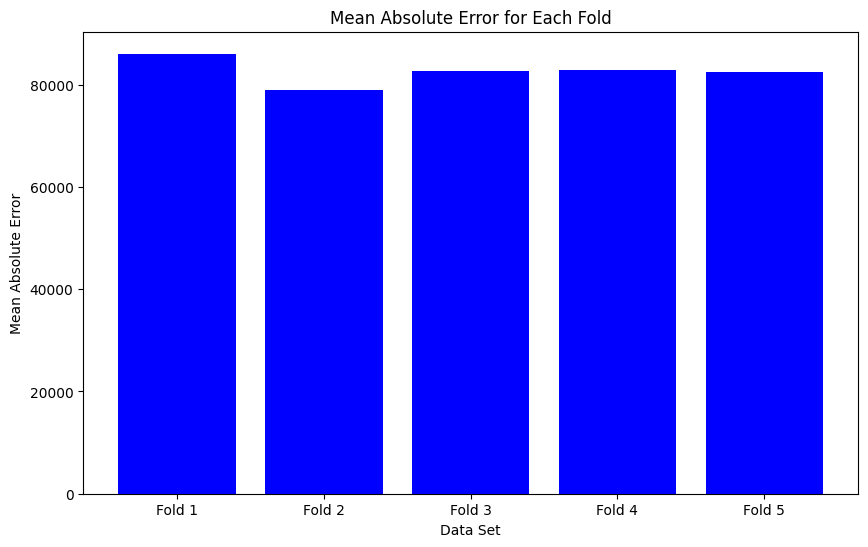

In [141]:
# Plotting the MAE for each fold and the test set
fold_labels = [f'Fold {i+1}' for i in range(len(cv_scores))]

mae_values = list(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(fold_labels, mae_values, color=['blue']*len(cv_scores))
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error for Each Fold')
plt.show()

## Train With Best Parameter

In [142]:
# Initialize the XGBoost model
model = XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=500, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
training_mae = mean_absolute_error(y_train, y_pred_train)
print(f'Mean Absolute Error on Training: {training_mae}')

testing_mae = mean_absolute_error(y_test, y_pred_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Mean Absolute Error on Training: 48163.15531532594
Mean Absolute Error on Testing: 78952.62358181538


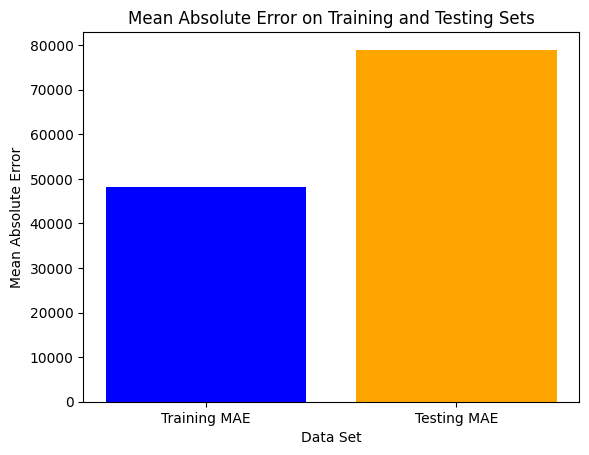

In [143]:
# Plotting the MAE
mae_values = [training_mae, testing_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Feature Important

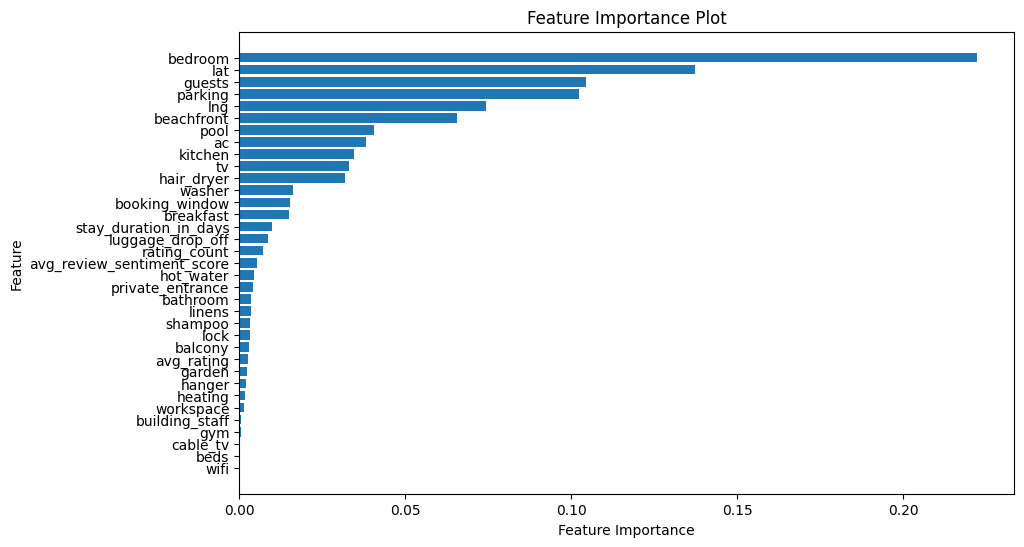

Mean Absolute Error: 78952.62358181538


In [144]:
import matplotlib.pyplot as plt

# Initialize a new XGBoost model with the best hyperparameters
best_model = XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=500, random_state=42)

# Train the model on the entire training dataset with the best hyperparameters
best_model.fit(X_train, y_train)

# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Create a DataFrame to store feature importances with corresponding column names
fi_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by feature importance values
fi_df = fi_df.sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(fi_df['Feature'], fi_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

### Predict with Feature Important 

In [209]:
important_column = ['bedroom',
                    'lat',  
                    'guests',
                    'parking', 
                    'beachfront',
                    'pool',
                    'ac',
                    'kitchen', 
                    'tv', 
                    'hair_dryer',
                    'washer',
                    'booking_window',
                    'breakfast', 
                    'stay_duration_in_days',
                    'bathroom', 
                    'beds']

X_important = df[important_column]
y_important = df['average_daily_rate']

In [210]:
X_important_train, X_important_test, y_important_train, y_important_test = train_test_split(X_important, y_important, test_size=0.2, random_state=42)

In [217]:
# Initialize the XGBoost model
model = XGBRegressor(learning_rate=0.3, max_depth=9, n_estimators=500, random_state=42, n_jobs=1)

# Fit the model on the training data
model.fit(X_important_train, y_important_train)

# Make predictions on the test data
y_pred_important_train = model.predict(X_important_train)
y_pred_important_test = model.predict(X_important_test)

# Evaluate the model
training_important_mae = mean_absolute_error(y_important_train, y_pred_important_train)
print(f'Mean Absolute Error on Training: {training_important_mae}')

testing_important_mae = mean_absolute_error(y_important_test, y_pred_important_test)
print(f'Mean Absolute Error on Testing: {testing_important_mae}')

Mean Absolute Error on Training: 49096.86349737242
Mean Absolute Error on Testing: 59862.81716175487


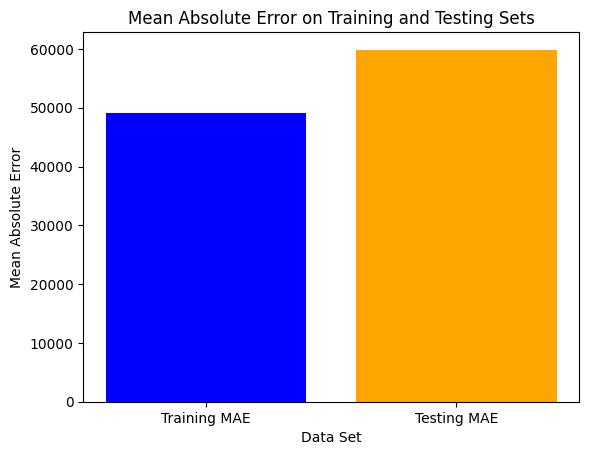

In [218]:
# Plotting the MAE
mae_values = [training_important_mae, testing_important_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

### Re-tuning

In [219]:
# Define the model
tuned_model = XGBRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.3, 0.4, 0.5],
    'max_depth': [9, 10, 11]
}

# Set up the Grid Search
grid_search = GridSearchCV(estimator=tuned_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', 
                           cv=5, 
                           verbose=2, 
                           n_jobs=-1)

# Fit the Grid Search
grid_search.fit(X_important_train, y_important_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Mean Absolute Error: {-best_score}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  10.5s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  10.6s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  10.6s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=  10.6s
[CV] END ...learning_rate=0.3, max_depth=9, n_estimators=500; total time=   9.2s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  18.7s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  18.9s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  19.1s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  17.9s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=1000; total time=  19.3s
[CV] END ..learning_rate=0.3, max_depth=9, n_estimators=2000; total time=  35.7s
[CV] END ..learning_rate=0.3, max_depth=9, n_es

### Cross Validation

In [222]:
# Define your XGBoost model
model = XGBRegressor(learning_rate=0.3, max_depth=10, n_estimators=2000, random_state=42)

# Define the k-fold cross-validation scheme
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the scoring function
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation and get scores
cv_scores = cross_val_score(model, X_important_train, y_important_train, cv=kf, scoring=scorer)

# Convert negative MAE to positive since we used greater_is_better=False
cv_scores = -cv_scores

# Print the cross-validation scores and their mean
print(f'Cross-Validation MAE Scores: {cv_scores}')
print(f'Mean Cross-Validation MAE: {np.mean(cv_scores)}')

# Fit the model on the entire training data
model.fit(X_important_train, y_important_train)

# Make predictions on the test data
y_pred_important_test = model.predict(X_important_test)

# Evaluate the model on the test data
testing_mae = mean_absolute_error(y_important_test, y_pred_important_test)
print(f'Mean Absolute Error on Testing: {testing_mae}')

Cross-Validation MAE Scores: [64166.77380666 59029.16025059 61671.85524658 61889.55540739
 60464.28518214]
Mean Cross-Validation MAE: 61444.325978672096
Mean Absolute Error on Testing: 59616.056397567154


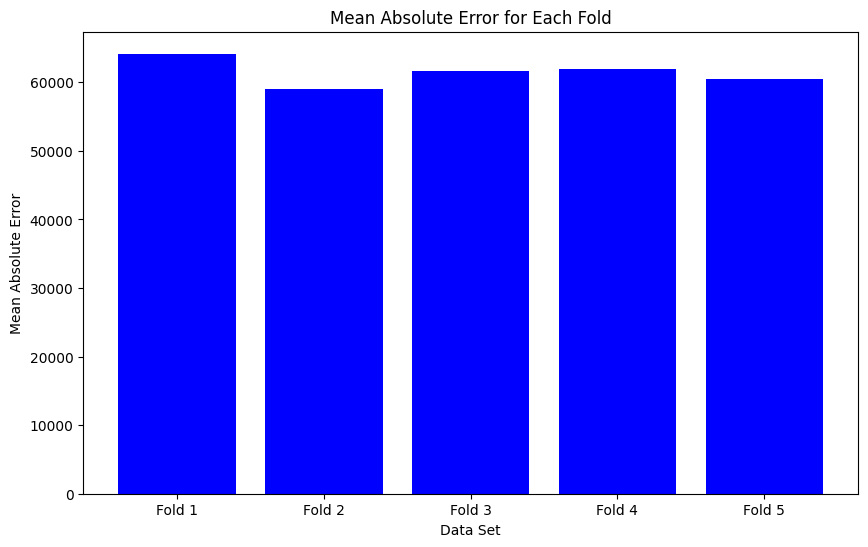

In [223]:
# Plotting the MAE for each fold and the test set
fold_labels = [f'Fold {i+1}' for i in range(len(cv_scores))]

mae_values = list(cv_scores)

plt.figure(figsize=(10, 6))
plt.bar(fold_labels, mae_values, color=['blue']*len(cv_scores))
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error for Each Fold')
plt.show()

In [224]:
# Initialize the XGBoost model
model = XGBRegressor(learning_rate=0.3, max_depth=10, n_estimators=2000, random_state=42, n_jobs=1)

# Fit the model on the training data
model.fit(X_important_train, y_important_train)

# Make predictions on the test data
y_pred_important_train = model.predict(X_important_train)
y_pred_important_test = model.predict(X_important_test)

# Evaluate the model
training_important_mae = mean_absolute_error(y_important_train, y_pred_important_train)
print(f'Mean Absolute Error on Training: {training_important_mae}')

testing_important_mae = mean_absolute_error(y_important_test, y_pred_important_test)
print(f'Mean Absolute Error on Testing: {testing_important_mae}')

Mean Absolute Error on Training: 48860.71638890795
Mean Absolute Error on Testing: 59616.056397567154


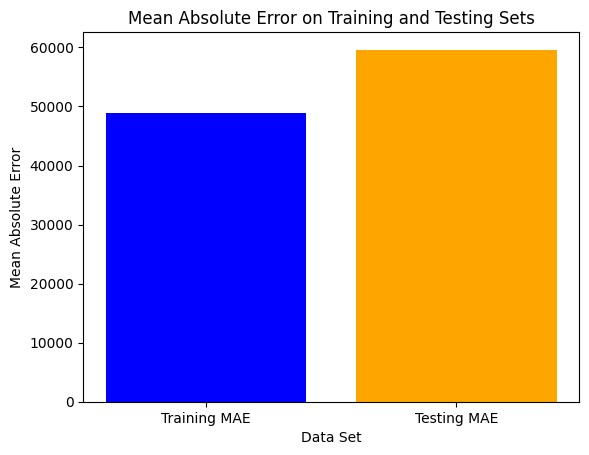

In [225]:
# Plotting the MAE
mae_values = [training_important_mae, testing_important_mae]
labels = ['Training MAE', 'Testing MAE']

plt.bar(labels, mae_values, color=['blue', 'orange'])
plt.xlabel('Data Set')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error on Training and Testing Sets')
plt.show()

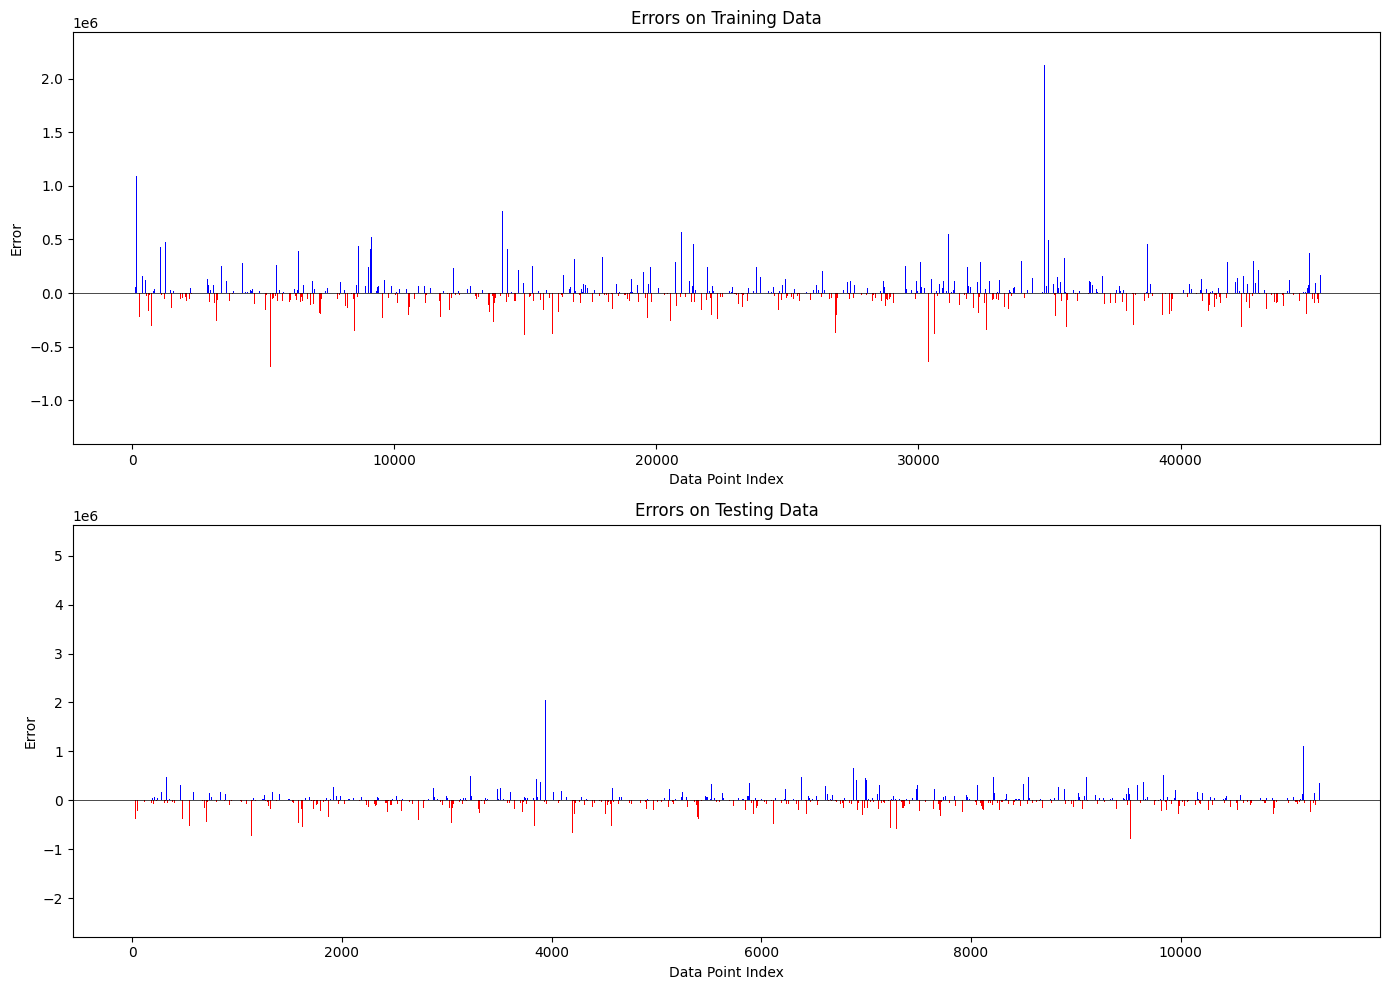

In [226]:
# Calculate errors
errors_train = y_important_train - y_pred_important_train
errors_test = y_important_test - y_pred_important_test

# Create a figure and axes
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Plot training errors
axs[0].bar(range(len(errors_train)), errors_train, color=np.where(errors_train > 0, 'blue', 'red'))
axs[0].axhline(0, color='black', linewidth=0.5)
axs[0].set_title('Errors on Training Data')
axs[0].set_xlabel('Data Point Index')
axs[0].set_ylabel('Error')
axs[0].set_ylim(min(errors_train) * 1.1, max(errors_train) * 1.1)

# Plot testing errors
axs[1].bar(range(len(errors_test)), errors_test, color=np.where(errors_test > 0, 'blue', 'red'))
axs[1].axhline(0, color='black', linewidth=0.5)
axs[1].set_title('Errors on Testing Data')
axs[1].set_xlabel('Data Point Index')
axs[1].set_ylabel('Error')
axs[1].set_ylim(min(errors_test) * 1.1, max(errors_test) * 1.1)

# Adjust layout
plt.tight_layout()
plt.show()

In [227]:
# Create DataFrames for training and testing datasets
train_data = pd.DataFrame({
    'index': X_important_train.index,
    'average_daily_rate': y_important_train,
    'predicted': y_pred_important_train, 
    'error': errors_train
})

test_data = pd.DataFrame({
    'index': X_important_test.index,
    'average_daily_rate': y_important_test,
    'predicted': y_pred_important_test, 
    'error': errors_test
})

# Optionally, concatenate the training and testing datasets into one DataFrame
combined_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

# Sort the combined DataFrame by the 'error' column in ascending order
sorted_combined_data = combined_data.sort_values(by='error', ascending=True).reset_index(drop=True)

# Display the first few rows of the sorted DataFrame
sorted_combined_data.head(10)


,index,average_daily_rate,predicted,error
0,23878,8.301597e+05,3366571.750,-2.536412e+06
1,51629,1.620324e+06,4064925.250,-2.444601e+06
2,51630,1.620324e+06,4064925.250,-2.444601e+06
3,9803,6.701236e+05,2922669.250,-2.252546e+06
4,9804,6.701236e+05,2922669.250,-2.252546e+06
5,40381,7.201565e+05,2939391.750,-2.219235e+06
6,55133,5.501100e+06,7436914.000,-1.935814e+06
7,2441,8.871249e+05,2409945.250,-1.522820e+06
8,3248,7.506161e+05,2032780.625,-1.282164e+06
9,3261,7.506161e+05,2032780.625,-1.282164e+06


In [228]:
# Filter the DataFrame to include only rows where the absolute value of the error is above 100,000
filtered_data = sorted_combined_data[sorted_combined_data['error'].abs() > 100000]

# Display the filtered DataFrame
filtered_data.shape

(8515, 4)

### Convert Model to PKL

In [188]:
import joblib

# Save the trained model to a file
joblib.dump(model, 'xgboost_model.pkl')

['xgboost_model.pkl']

### Load and test the model

In [189]:
# Load the trained XGBoost model
xgboost_model = joblib.load('xgboost_model.pkl')

# Use XGBoost model to make predictions
xgboost_predictions_test = xgboost_model.predict(X_important_test)

# Now you can use these predictions in your TensorFlow code
print("Predictions:", xgboost_predictions_test[:10])
print("Actual Prices:", y_important_test[:10])

Predictions: [ 562531.7   523922.03  412767.5  1909012.5   460089.8   372578.97
  480019.75  403704.5   448567.72  975110.6 ]
Actual Prices: 3003     3.895795e+05
15000    5.226072e+05
35864    3.900705e+05
46528    1.910377e+06
14579    5.000842e+05
13480    3.725928e+05
26793    4.800620e+05
53618    2.500347e+05
50848    3.825765e+05
52849    9.751940e+05
Name: average_daily_rate, dtype: float64


## Data Pipeline for Prediction

In [192]:
predicted_column = ['property_name', 
                    'room_id',
                    'bedroom',
                    'lat',  
                    'guests',
                    'parking', 
                    'beachfront',
                    'pool',
                    'ac',
                    'kitchen', 
                    'tv', 
                    'hair_dryer',
                    'washer',
                    'booking_window',
                    'breakfast', 
                    'stay_duration_in_days',
                    'bathroom', 
                    'beds',
                    'average_daily_rate']

X_predicted = df[predicted_column]

### Drop Duplicated Data

In [193]:
distinct_data = X_predicted.drop_duplicates(subset=['property_name', 'room_id'])

### Save Distinct Data

In [194]:
distinct_data.to_csv('xgboost_distinct_data.csv', index=False)

### Pipeline with existing property

In [200]:
import pandas as pd
from datetime import date
import joblib


def booking_window(today, check_in):
    return (check_in - today).days

def stay_duration(check_in, check_out):
    return (check_out - check_in).days

def predict(predicted_df, property_name, room_id, check_in, check_out):
    # Select property name and room_id
    filtered_df = predicted_df[(predicted_df['property_name'] == property_name) & 
                              (predicted_df['room_id'] == room_id)].copy()
    
    if filtered_df.empty:
        raise ValueError("No matching property_name and room_id found in the data")
    
    # Save the current price
    current_price = filtered_df['average_daily_rate'].values
    
    # Drop unnecessary columns
    filtered_df.drop(columns=['property_name', 'room_id', 'average_daily_rate'], inplace=True)
    
    # Feature engineering booking window
    today = date.today()
    booking_window_days = booking_window(today, check_in)
    
    # Feature engineering stay duration
    stay_duration_days = stay_duration(check_in, check_out)
    
    # Replace values in columns
    filtered_df['stay_duration_in_days'] = stay_duration_days
    filtered_df['booking_window'] = booking_window_days
    
    # print("Filtered DataFrame after replacing values:\n", filtered_df)
    print("Booking window (days):", booking_window_days)
    print("Stay duration (days):", stay_duration_days)
    
    # Predict
    # xgboost_model = joblib.load('xgboost_model.pkl')
    xgboost_model = joblib.load(os.path.join(os.getcwd(), 'xgboost_model.pkl'))
    xgboost_predictions_test = xgboost_model.predict(filtered_df)
    
    return xgboost_predictions_test, current_price

def format_currency(value):
    value_str = f"{value:,.2f}"
    value_str = value_str.replace(',', 'X').replace('.', ',').replace('X', '.')
    return f"Rp {value_str}"

# Example usage
check_in = date(2024, 12, 24)
check_out = date(2024, 12, 25)

prediction, current_price = predict(distinct_data, 'Amazon Guesthouse', 397693, check_in, check_out)
formatted_current_price = format_currency(current_price[0])
formatted_prediction = format_currency(prediction[0])

print("Current Price:", formatted_current_price)
print("Prediction:", formatted_prediction)

Booking window (days): 195
Stay duration (days): 1
Current Price: Rp 446.768,58
Prediction: Rp 914.532,94


### Pipeline with new property

In [203]:
from datetime import date
import joblib

def booking_window(today, check_in):
    return (check_in - today).days

def stay_duration(check_in, check_out):
    return (check_out - check_in).days

def predict_new_data(bedroom, 
                     lat, 
                     guests, 
                     parking, 
                     beachfront, 
                     pool, 
                     ac,
                     kitchen, 
                     tv, 
                     hair_dryer, 
                     washer,
                     breakfast, 
                     bathroom, 
                     beds, 
                     check_in, 
                     check_out):
    
    # Feature engineering booking window
    today = date.today()
    booking_window_days = booking_window(today, check_in)
    
    # Feature engineering stay duration
    stay_duration_days = stay_duration(check_in, check_out)
    
    data = np.array([[bedroom, lat, guests, parking, 
                      beachfront, pool, ac, kitchen, 
                      tv, hair_dryer, washer,
                      booking_window_days, breakfast, 
                      stay_duration_days,
                      bathroom, beds]])
    
    xgboost_model = joblib.load('xgboost_model.pkl')
    xgboost_prediction = xgboost_model.predict(data)
    
    return xgboost_prediction


def format_currency(value):
    value_str = f"{value:,.2f}"
    value_str = value_str.replace(',', 'X').replace('.', ',').replace('X', '.')
    return f"Rp {value_str}"


check_in = date(2024, 12, 24)
check_out = date(2024, 12, 25)

prediction = predict_new_data(1, 0.1, 1, 
                              1, 1, 1, 
                              1, 1, 1, 
                              1, 1, 1, 
                              1, 1, check_in, check_out)
print("Prediction:", format_currency(prediction[0]))

# bedroom, lat, guests, parking, 
# beachfront, pool, ac, kitchen, 
# tv, hair_dryer, washer,
# booking_window, breakfast, 
# stay_duration_in_days,
# bathroom, beds

Prediction: Rp 701.037,38
